# Assignment

In [151]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from Chess_env import *
import pandas as pd
import tensorflow as tf
import keras
from collections import deque
import random
import pandas as pd
from tqdm import trange
import wandb

# seed for reproducible results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [152]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)
testing_env = Chess_Env(size_board)

N_episodes = 100000
N_test_episodes = 5000
max_T = 200 # max iterations of one episode (to avoid endless loop)

#colors for plots
sarsa_color = "#1f78b4"
sarsa_color_changed = "#a6cee3"
qlearning_color = "#33a02c"
qlearning_replay_color = "#b2df8a"
qlearning_replay_adapted_color = "#ff7f00"
sarsa_adapted_reward_color = "#e31a1c"
qlearning_color_rms = "#fdbf6f"
sarsa_color_rms = "#fb9a99"


### Agent

In [173]:
# GENERAL AGENT CLASS, used by both SARSA and Q-Learning
class GeneralAgent:

    # BUILD NEURAL NETWORK with 1 hidden layer with 200 and ReLU activation
    def build_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(200, input_shape=(np.shape(X)), activation='relu'))
        model.add(keras.layers.Dense(32, activation='linear'))
        return model

    # COMPILE MODEL with either Adam or RMSprop
    def compile_model(self, opt="Adam"):
        if opt == "Adam":
            self.model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
        elif opt == "RMSprop":
            self.model.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                                                                 rho=0.9,
                                                                                 momentum=0.0,
                                                                                 epsilon=1e-07,
                                                                                 centered=False,
                                                                                 name="RMSprop"),
                               metrics=["accuracy"])

    # EPSILON GREEDY POLICY to select next action
    def epsilon_greedy(self, X, allowed_a, epsilon):
        allowed_ind,_=np.where(allowed_a==1) # only consider allowed actions

        # if the random value is smaller than epsilon take a random action from the allowed actions
        rand_value=np.random.uniform(0,1) 
        if rand_value < epsilon:
            a = np.random.choice(allowed_ind) 

        # else select action with max predicted value 
        else: 
            X_reshape = np.reshape(X, (1, self.N_in))           # reshape to fit model
            predicted = self.model.predict(X_reshape)           # predict Q-values for X
            predicted_allowed = np.take(predicted, allowed_ind) # only take Q-values with allowed indices 
            a_p = np.argmax(predicted_allowed)                  # select argmax of predicted
            a = allowed_ind[a_p]                                # take correct position of action

        return a

    # LOAD MODEL WEIGHTS
    def load(self, name):
        self.model.load_weights(name)
    
    # SAVE MODEL WEIGHTS
    def save(self, name):
        self.model.save_weights(name)
        

## Task 3: Deep SARSA
Implement SARSA algorithm and produce two plots that show the reward per game and the number of moves per game vs training time.

**Agent for SARSA**

In [219]:
# SARSA AGENT CLASS inherits from general agent, all functions and variables relevant to SARSA
class SarsaAgent(GeneralAgent):
    
    def __init__(self, N_a, N_in, epsilon=0.2, beta=0.00005, gamma=0.85, eta=0.0035, N_episodes=100000):
        # SAVING VARIABLES
        # initialize parameters
        self.N_a = N_a
        self.N_in = N_in

        self.epsilon = epsilon     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
        self.beta = beta           # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
        self.gamma = gamma         # THE DISCOUNT FACTOR
        self.eta = eta             # THE LEARNING RATE

        self.R_save = np.zeros([N_episodes])
        self.N_moves_save = np.zeros([N_episodes])

        self.model = self.build_model()

    # TRAIN MODEL with SARSA update rule
    def train_model(self, X, a, R, X_next, a_next, Done):        
        target = R
        X_reshape = np.reshape(X, (1, N_in))
        target_f = self.model.predict(X_reshape)

        if Done == 0:
            target = (R + self.gamma * self.model.predict(np.array([X_next]))[0])[a_next]   # SARSA update rule

        target_f[0][a] = target
        self.model.fit(X_reshape, target_f, epochs=1, verbose=0)    # train model


### SARSA algorithm

In [77]:
def sarsa_algorithm(sarsa_agent, N_episodes, max_T, adapted_reward=False):
    wandb.config = {
        "N_episodes": N_episodes,
        "max_T": max_T
    }
    t = trange(N_episodes, desc='Bar desc', leave=True)
    for e in t:
        # epsilon decay
        epsilon = sarsa_agent.epsilon / (1 + sarsa_agent.beta * e)
        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        
        S, X, allowed_a = env.Initialise_game()  ## INITIALISE GAME

        a = sarsa_agent.epsilon_greedy(X, allowed_a, epsilon)   # get action from greedy
        a_next = None # set a_next to None (needed if we solve in one step and train)
        time = 1
        
        while Done == 0:
            # take action a
            S_next, X_next, allowed_a_next, R, Done = env.OneStep(a, adapted_reward)

            # if number of iterations is max nr of iterations, set to Done  
            if time == max_T:
                Done = 1 

            # THE EPISODE HAS NOT ENDED: epsilon greedy to get next action   
            if Done == 0:
                a_next = sarsa_agent.epsilon_greedy(X_next, allowed_a_next, epsilon) # get action from greedy
            
            # train model 
            sarsa_agent.train_model(X, a, R, X_next, a_next, Done)
            
            ## wandb logging for plots, remove if not using wandb
            wandb.log({"Epoch": e})
            wandb.log({"moves_average": sarsa_agent.N_moves_save[e-100:e].mean() if e > 100 else 0})
            wandb.log({"reward_average": sarsa_agent.R_save[e-100:e].mean() if e > 100 else 0})
            
            ## THE EPISODE HAS ENDED, update reward and number of moves
            if Done == 1:
                # progress bar
                t.set_description(f"Epoch {e}/{N_episodes}")
                t.set_postfix(moves_average = sarsa_agent.N_moves_save[e-100:e].mean() if e > 100 else 0,
                              reward_average = sarsa_agent.R_save[e-100:e].mean() if e > 100 else 0)   
                sarsa_agent.R_save[e] = np.copy(R)
                sarsa_agent.N_moves_save[e] = np.copy(time)
                break
            
            # update parameters (state, allowed actions, action)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
            a = np.copy(a_next)
            time += 1

In [ ]:
# SARSA
# initialize wandb
wandb.init(project="chess_rl", name="SARSA", entity="sarsagirls") # change to your username

# initialize a game
S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0] 
sarsa_agent = SarsaAgent(N_a, N_in) #initialize our sarsa agent network
sarsa_agent.compile_model() # compile the network

# sarsa algorithm
sarsa_algorithm(sarsa_agent, N_episodes, max_T)

# save model           
sarsa_agent.save("sarsa.h5")

#transform number of moves and rewards to dataframe with EMA
df_n_moves_sarsa = pd.DataFrame({'moves': sarsa_agent.N_moves_save})
df_reward_sarsa = pd.DataFrame({'rewards': sarsa_agent.R_save})
ema_n_moves_sarsa = df_n_moves_sarsa.ewm(com=5000).mean()
ema_reward_sarsa = df_reward_sarsa.ewm(com=5000).mean()
# save df as csv
df_n_moves_sarsa.to_csv("csv/df_n_moves_sarsa.csv")
df_reward_sarsa.to_csv("csv/df_reward_sarsa.csv")
ema_n_moves_sarsa.to_csv("csv/ema_n_moves_sarsa.csv")
ema_reward_sarsa.to_csv("csv/ema_reward_sarsa.csv")

### Plots

**Number of Moves per Game** 

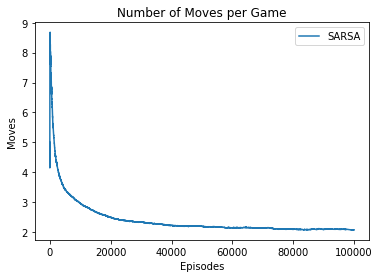

In [153]:
# load data from csv file (take ema file)
sarsa_moves = pd.read_csv('csv/ema_n_moves_sarsa.csv')
sarsa_moves = sarsa_moves.iloc[: , 1:]

# plot
plt.plot(sarsa_moves[10:], label="SARSA", color=sarsa_color)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game")
plt.legend()
plt.savefig("pdf/moves_sarsa.pdf")
plt.show()

**Reward per Game**

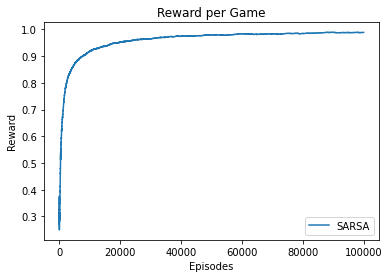

In [154]:
# load data from csv file (take ema)
sarsa_reward = pd.read_csv('csv/ema_reward_sarsa.csv')
sarsa_reward = sarsa_reward.iloc[: , 1:]

# plot
plt.plot(sarsa_reward[10:], label="SARSA", color=sarsa_color)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game")
plt.legend()
plt.savefig("pdf/reward_sarsa.pdf")
plt.show()

## Task 4: Adapt Parameters: Discount Factor and Speed of Decaying Trend

We change the discount factor gamma from 0.85 to 0.9, the speed beta from 0.00005 to 0.000005, the decaing trend epsilon from 0.2 to 0.1.

In [ ]:
# SARSA with changed epsilon, beta, gamma

wandb.init(project="chess_rl", name="SARSA Adapted Parameters", entity="sarsagirls")

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0]

# adapted epsilon, beta and gamma parameters
epsilon=0.1
beta=0.000005
gamma=0.9

sarsa_agent_changed = SarsaAgent(N_a, N_in, epsilon, beta, gamma)
sarsa_agent_changed.compile_model()

# sarsa algorithm with sarsa agent with changed parameters
sarsa_algorithm(sarsa_agent_changed, N_episodes, max_T)

#save model         
sarsa_agent_changed.save("sarsachess_changed.h5")

#transform number of moves and rewards to dataframe with EMA
df_n_moves_sarsa_changed = pd.DataFrame({'moves': sarsa_agent_changed.N_moves_save})
df_reward_sarsa_changed = pd.DataFrame({'rewards': sarsa_agent_changed.R_save})
ema_n_moves_sarsa_changed = df_n_moves_sarsa_changed.ewm(com=5000).mean()
ema_reward_sarsa_changed = df_reward_sarsa_changed.ewm(com=5000).mean()
# save df as csv
df_n_moves_sarsa_changed.to_csv("csv/df_n_moves_sarsa_changed.csv")
df_reward_sarsa_changed.to_csv("csv/df_reward_sarsa_changed.csv")
ema_n_moves_sarsa_changed.to_csv("csv/ema_n_moves_sarsa_changed.csv")
ema_reward_sarsa_changed.to_csv("csv/ema_reward_sarsa_changed.csv")

### Plots

**Number of Moves Per Game: Comparison SARSA vs. SARSA with Adapted Parameters**

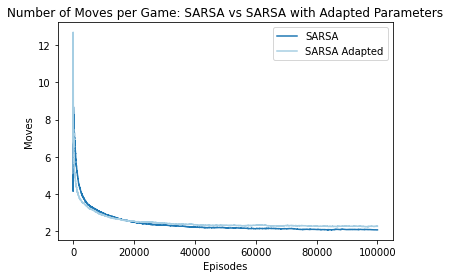

In [155]:
# load data from csv file (take ema file)
sarsa_moves = pd.read_csv('csv/ema_n_moves_sarsa.csv')
sarsa_moves = sarsa_moves.iloc[: , 1:]

sarsa_moves_changed = pd.read_csv('csv/ema_n_moves_sarsa_changed.csv')
sarsa_moves_changed = sarsa_moves_changed.iloc[: , 1:]

# plot
plt.plot(sarsa_moves[10:], label="SARSA", color=sarsa_color)
plt.plot(sarsa_moves_changed[10:], label="SARSA Adapted", color=sarsa_color_changed)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game: SARSA vs SARSA with Adapted Parameters")
plt.legend()
plt.savefig("pdf/moves_sarsa_parameters_comparison.pdf")
plt.show()

**Reward per Game: Comparison SARSA vs. SARSA with Adapted Parameters**

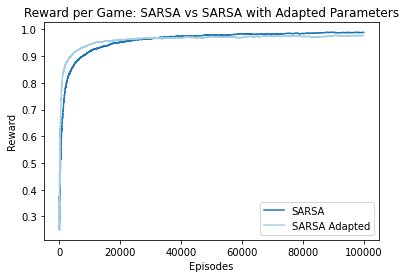

In [156]:
# load data from csv file (take ema)
sarsa_reward = pd.read_csv('csv/ema_reward_sarsa.csv')
sarsa_reward = sarsa_reward.iloc[: , 1:]


sarsa_reward_changed = pd.read_csv('csv/df_reward_sarsa_changed.csv')
sarsa_reward_changed = sarsa_reward_changed.iloc[: , 1:]
sarsa_reward_changed = sarsa_reward_changed.ewm(com=5000).mean()

# plot
plt.plot(sarsa_reward[10:], label="SARSA", color=sarsa_color)
plt.plot(sarsa_reward_changed[10:], label="SARSA Adapted", color=sarsa_color_changed)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game: SARSA vs SARSA with Adapted Parameters")
plt.legend()
plt.savefig("pdf/reward_sarsa_parameters_comparison.pdf")
plt.show()

## Task 5: Deep Q-Learning 

**Deep Q-Learning Agent**

In [174]:
class DQNAgent(GeneralAgent):
    def __init__(self, N_a, N_in, N_episodes):
        # SAVING VARIABLES
        # initialize parameters
        self.N_a = N_a
        self.N_in = N_in

        self.epsilon = 0.2      # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
        self.beta = 0.00005     # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
        self.gamma = 0.85       # THE DISCOUNT FACTOR
        self.eta = 0.0035       # THE LEARNING RATE

        self.R_save = np.zeros([N_episodes]) # 
        self.N_moves_save = np.zeros([N_episodes])

        self.model = self.build_model()

        self.memory = deque(maxlen=2000)
        self.batch_size = 32

    # TRAIN MODEL with Q-LEarning update rule
    def train_model(self, X, a, R, X_next, Done):
        target = R
        X_reshape = np.reshape(X, (1, self.N_in))
        target_f = self.model.predict(X_reshape)
        if Done == 0:
            target = (R + self.gamma *
                        np.amax(self.model.predict(np.array([X_next]))[0])) #Q-Learning update rule
        target_f[0][a] = target
        self.model.fit(X_reshape, target_f, epochs=1, verbose=0)

    # EXPERIENCE REPLAY, select batch from memory and train model on this batch
    def replay(self): 
        minibatch = random.sample(self.memory, self.batch_size)
        for X, a, R, X_next, Done in minibatch:
            self.train_model(X, a, R, X_next, Done)

    # append values to memory (for replay)
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


### Q-Learning algorithm

In [175]:
def qlearning_algorithm(q_agent, N_episodes, max_T, replay=False, adapted_reward=False):
    wandb.config = {
        "N_episodes": N_episodes,
        "max_T": max_T
    }
    t = trange(N_episodes, desc='Bar desc', leave=True)
    n_steps = 0
    for e in t:
        epsilon = q_agent.epsilon / (1 + q_agent.beta * e)
        Done = 0
        S, X, allowed_a = env.Initialise_game() # select state X randomly
        time = 1

        while Done == 0:
            a = q_agent.epsilon_greedy(X, allowed_a, epsilon) #choose a from X 
            S_next, X_next, allowed_a_next, R, Done = env.OneStep(a, adapted_reward) # take action
            # when using experience replay, save result and do replay 
            if replay:
                q_agent.memorize(X, a, R, X_next, Done) # append results to memory
                if len(q_agent.memory) > q_agent.batch_size and n_steps%100 == 0:
                    q_agent.replay() # replay
                
            # else do epsilon greedy and train model
            else:
                q_agent.train_model(X, a, R, X_next, Done)
                
            ## wandb logging for plots, remove if not using wandb
            wandb.log({"Epoch": e})
            wandb.log({"moves_average": q_agent.N_moves_save[e-100:e].mean() if e > 100 else 0})
            wandb.log({"reward_average": q_agent.R_save[e-100:e].mean() if e > 100 else 0})
            
            ## IF DONE: save reward and number of moves
            if Done == 1 or time >= max_T:
                # progress bar    
                t.set_description(f"Epoch {e}/{N_episodes}")
                t.set_postfix(moves_average = q_agent.N_moves_save[e-100:e].mean() if e > 100 else 0,
                              reward_average = q_agent.R_save[e-100:e].mean() if e > 100 else 0)
                q_agent.R_save[e] = np.copy(R)
                q_agent.N_moves_save[e] = np.copy(time)
                break
             
            
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
            time += 1
            n_steps += 1

**Training Q-Learning algorithm with Experience Replay**

In [ ]:
# Q_Learning

wandb.init(project="chess_rl", name="Q-Learning with Replay", entity="sarsagirls")

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
q_agent = DQNAgent(N_a, N_in)
q_agent.compile_model()

# q-learning algorithm with replay=True
qlearning_algorithm(q_agent, N_episodes, maxT, True)

# save model          
q_agent.save("qchess_replay.h5")

# for plotting
df_n_moves_qlearning_replay = pd.DataFrame({'moves': q_agent.N_moves_save})
df_reward_qlearning_replay = pd.DataFrame({'rewards': q_agent.R_save})
ema_n_moves_qlearning_replay = df_n_moves_qlearning_replay.ewm(com=5000).mean()
ema_reward_qlearning_replay = df_reward_qlearning_replay.ewm(com=5000).mean()
# save df as csv
ema_reward_qlearning_replay.to_csv("csv/ema_reward_qlearning_replay.csv")
ema_n_moves_qlearning_replay.to_csv("csv/ema_n_moves_qlearning_replay.csv")
df_reward_qlearning_replay.to_csv("csv/df_reward_qlearning_replay.csv")
df_n_moves_qlearning_replay.to_csv("csv/df_n_moves_qlearning_replay.csv")

**Training Q-Learning algorithm without Experience Replay**

In [ ]:
# Q_Learning without replay

wandb.init(project="chess_rl", name="Q-Learning without Replay", entity="sarsagirls")

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
qlearning_agent = DQNAgent(N_a, N_in)
qlearning_agent.compile_model()

# q-learning algorithm with replay=False
qlearning_algorithm(qlearning_agent, N_episodes, max_T, False)

# save model
qlearning_agent.save("qlearning_chess.h5")

# for plotting
df_n_moves_qlearning = pd.DataFrame({'moves': qlearning_agent.N_moves_save})
df_reward_qlearning = pd.DataFrame({'rewards': qlearning_agent.R_save})
ema_n_moves_qlearning = df_n_moves_qlearning.ewm(com=5000).mean()
ema_reward_qlearning = df_reward_qlearning.ewm(com=5000).mean()
# save df as csv
ema_reward_qlearning.to_csv("csv/ema_reward_qlearning.csv")
ema_n_moves_qlearning.to_csv("csv/ema_n_moves_qlearning.csv")
df_reward_qlearning.to_csv("csv/df_reward_qlearning.csv")
df_n_moves_qlearning.to_csv("csv/df_n_moves_qlearning.csv")

### Plots

**Number of Moves per Game: Q-Learning with and without Experience Replay**

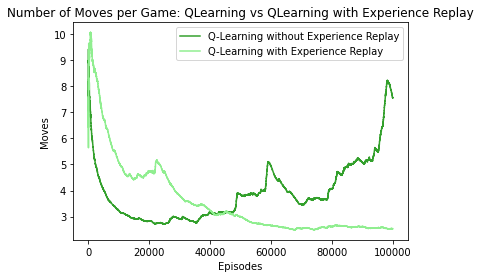

In [177]:
# load data from csv file (take ema file)
qlearning_moves = pd.read_csv("csv/ema_n_moves_qlearning.csv")
qlearning_moves = qlearning_moves.iloc[: , 1:]

qlearning_moves_replay = pd.read_csv("csv/ema_n_moves_qlearning_replay.csv")
qlearning_moves_replay = qlearning_moves_replay.iloc[: , 1:]

# plot
plt.plot(qlearning_moves[10:], label="Q-Learning without Experience Replay", color=qlearning_color)
plt.plot(qlearning_moves_replay[10:], label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game: QLearning vs QLearning with Experience Replay")
plt.legend()
plt.savefig("pdf/moves_qlearning_replay_comparison.pdf")
plt.show()

**Reward per Game: Q-Learning with and without Experience Replay**

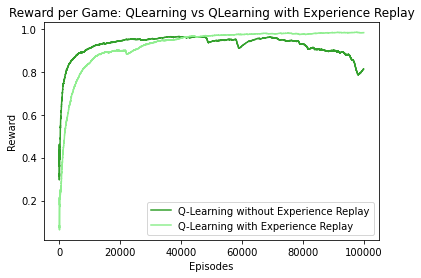

In [178]:
# load data from csv file (take ema file)
qlearning_reward = pd.read_csv("csv/ema_reward_qlearning.csv")
qlearning_reward  = qlearning_reward .iloc[: , 1:]

qlearning_reward_replay = pd.read_csv("csv/ema_reward_qlearning_replay.csv")
qlearning_reward_replay = qlearning_reward_replay.iloc[: , 1:]

# plot
plt.plot(qlearning_reward[10:] , label="Q-Learning without Experience Replay", color=qlearning_color)
plt.plot(qlearning_reward_replay[10:], label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game: QLearning vs QLearning with Experience Replay")
plt.legend()
plt.savefig("pdf/reward_qlearning_replay_comparison.pdf")
plt.show()

**SARSA vs Q-Learning**

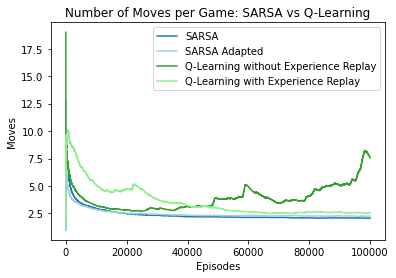

In [179]:
# load data from csv file (take ema file)
qlearning_moves = pd.read_csv("csv/ema_n_moves_qlearning.csv")
qlearning_moves = qlearning_moves.iloc[: , 1:]

qlearning_moves_replay = pd.read_csv("csv/ema_n_moves_qlearning_replay.csv")
qlearning_moves_replay = qlearning_moves_replay.iloc[: , 1:]

sarsa_moves = pd.read_csv('csv/ema_n_moves_sarsa.csv')
sarsa_moves = sarsa_moves.iloc[: , 1:]

sarsa_moves_changed = pd.read_csv('csv/ema_n_moves_sarsa_changed.csv')
sarsa_moves_changed = sarsa_moves_changed.iloc[: , 1:]

# plot
plt.plot(sarsa_moves, label="SARSA", color=sarsa_color)
plt.plot(sarsa_moves_changed, label="SARSA Adapted", color=sarsa_color_changed)
plt.plot(qlearning_moves, label="Q-Learning without Experience Replay", color=qlearning_color)
plt.plot(qlearning_moves_replay, label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game: SARSA vs Q-Learning")
plt.legend()
plt.savefig("pdf/moves_qlearning_sarsa_comparison.pdf")
plt.show()

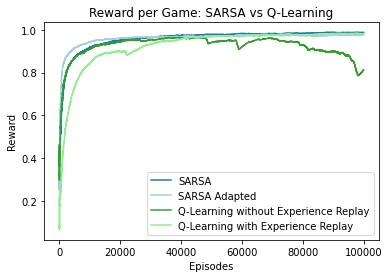

In [191]:
# load data from csv file (take ema file)
qlearning_reward = pd.read_csv("csv/ema_reward_qlearning.csv")
qlearning_reward  = qlearning_reward .iloc[: , 1:]

qlearning_reward_replay = pd.read_csv("csv/ema_reward_qlearning_replay.csv")
qlearning_reward_replay = qlearning_reward_replay.iloc[: , 1:]

sarsa_reward = pd.read_csv('csv/ema_reward_sarsa.csv')
sarsa_reward = sarsa_reward.iloc[: , 1:]

sarsa_reward_changed = pd.read_csv('csv/df_reward_sarsa_changed.csv')
sarsa_reward_changed = sarsa_reward_changed.iloc[: , 1:]
sarsa_reward_changed = sarsa_reward_changed.ewm(com=5000).mean()

# plot
plt.plot(sarsa_reward[10:], label="SARSA", color=sarsa_color)
plt.plot(sarsa_reward_changed[10:], label="SARSA Adapted", color=sarsa_color_changed)
plt.plot(qlearning_reward[10:], label="Q-Learning without Experience Replay", color=qlearning_color)
plt.plot(qlearning_reward_replay[10:], label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game: SARSA vs Q-Learning")
plt.legend()
plt.savefig("pdf/reward_qlearning_sarsa_comparison.pdf")
plt.show()

## Task 6: Change Reward

We change the reward system in the chess environment. If the action results in a win, we reward 10, if it's a draw we keep the previous reward of 0, and for actions that don't result in Done we punish with a reward of -0.25.

**SARSA with Adapted Reward**

In [ ]:
# SARSA Adapted Reward

wandb.init(project="chess_rl", name="SARSA Adapted Reward", entity="sarsagirls")

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0]
sarsa_r_agent = SarsaAgent(N_a, N_in)

sarsa_r_agent.compile_model()
#SARSA algorithm with adapted_reward=True
sarsa_algorithm(sarsa_r_agent, N_episodes, max_T, True)

# save model
sarsa_r_agent.save("sarsachess_adapted_reward.h5")

# for plotting
df_n_moves_sarsa_adapted_reward = pd.DataFrame({'moves': sarsa_r_agent.N_moves_save})
df_reward_sarsa_adapted_reward = pd.DataFrame({'rewards': sarsa_r_agent.R_save})
ema_n_moves_sarsa_adapted_reward = df_n_moves_sarsa_adapted_reward.ewm(com=5000).mean() 
ema_reward_sarsa_adapted_reward = df_reward_sarsa_adapted_reward.ewm(com=5000).mean()
# save df as csv
ema_n_moves_sarsa_adapted_reward.to_csv("csv/ema_n_moves_sarsa_adapted_reward.csv")
ema_reward_sarsa_adapted_reward.to_csv("csv/ema_reward_sarsa_adapted_reward.csv")
df_n_moves_sarsa_adapted_reward.to_csv("csv/df_n_moves_sarsa_adapted_reward.csv")
df_reward_sarsa_adapted_reward.to_csv("csv/df_reward_sarsa_adapted_reward.csv")

**Q-Learning with Adapted Reward**

In [ ]:
# Q_Learning Adapted Reward

wandb.init(project="chess_rl", name="QLearning Adapted Reward", entity="sarsagirls")

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
q_agent_adapted = DQNAgent(N_a, N_in)
q_agent_adapted.compile_model()

# Q-Learning algorithm with replay=True and adapted_reward=True
qlearning_algorithm(q_agent_adapted, N_episodes, max_T, True, True)

# save model         
q_agent_adapted.save("qchess_adapted_reward.h5")

# for plotting
df_n_moves_qlearning_replay_adapted_reward = pd.DataFrame({'moves': q_agent_adapted.N_moves_save})
df_reward_qlearning_replay_adapted_reward = pd.DataFrame({'rewards': q_agent_adapted.R_save})
ema_n_moves_qlearning_replay_adapted_reward = df_n_moves_qlearning_replay_adapted_reward.ewm(com=5000).mean()
ema_reward_qlearning_replay_adapted_reward = df_reward_qlearning_replay_adapted_reward.ewm(com=5000).mean()
# save df as csv
df_reward_qlearning_replay_adapted_reward.to_csv("csv/df_reward_qlearning_replay_adapted_reward.csv")
df_n_moves_qlearning_replay_adapted_reward.to_csv("csv/df_n_moves_qlearning_replay_adapted_reward.csv")
ema_n_moves_qlearning_replay_adapted_reward.to_csv("csv/ema_n_moves_qlearning_replay_adapted_reward.csv")
ema_reward_qlearning_replay_adapted_reward.to_csv("csv/ema_reward_qlearning_replay_adapted_reward.csv")

### Plots

**Number of Moves per Game**

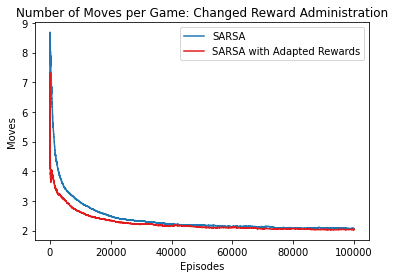

In [160]:
# load data from csv file (take ema file)
sarsa_moves = pd.read_csv('csv/ema_n_moves_sarsa.csv')
sarsa_moves = sarsa_moves.iloc[: , 1:]

sarsa_moves_adapted_reward = pd.read_csv('csv/ema_n_moves_sarsa_adapted_reward.csv')
sarsa_moves_adapted_reward = sarsa_moves_adapted_reward.iloc[: , 1:]

# plot
plt.plot(sarsa_moves[10:], label="SARSA", color=sarsa_color)
plt.plot(sarsa_moves_adapted_reward[10:], label="SARSA with Adapted Rewards", color=sarsa_adapted_reward_color)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game: Changed Reward Administration")
plt.legend()
plt.savefig("pdf/moves_adapted_reward_comparison.pdf")
plt.show()

In [ ]:
qlearning_moves_replay_adapted_reward = pd.read_csv("csv/ema_n_moves_qlearning_replay_adapted_reward.csv")
qlearning_moves_replay_adapted_reward = qlearning_moves_replay_adapted_reward.iloc[: , 1:]

qlearning_moves_replay = pd.read_csv("csv/ema_n_moves_qlearning_replay.csv")
qlearning_moves_replay = qlearning_moves_replay.iloc[: , 1:]

# plot
plt.plot(qlearning_moves_replay, label="Q-Learning", color=qlearning_replay_color)
plt.plot(qlearning_moves_replay_adapted_reward, label="Q-Learning with Adapted Rewards", color=qlearning_replay_adapted_color)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game: Changed Reward Administration")
plt.legend()
plt.savefig("pdf/moves_adapted_reward_comparison.pdf")
plt.show()

**Reward per Game**

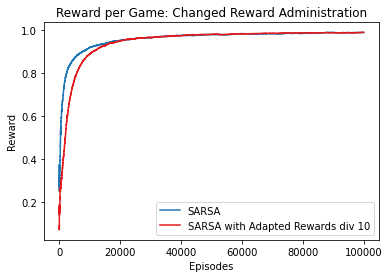

In [161]:
# load data from csv file (take ema file)
sarsa_reward = pd.read_csv('csv/ema_reward_sarsa.csv')
sarsa_reward = sarsa_reward.iloc[: , 1:]

sarsa_reward_adapted_reward = pd.read_csv('csv/ema_reward_sarsa_adapted_reward.csv')
sarsa_reward_adapted_reward = sarsa_reward_adapted_reward.iloc[: , 1:]

sarsa_reward_adapted_reward_div10 = sarsa_reward_adapted_reward.div(10)

# plot
plt.plot(sarsa_reward[10:], label="SARSA", color=sarsa_color)
# plt.plot(sarsa_reward_adapted_reward, label="SARSA with Adapted Rewards", color=sarsa_adapted_reward_color)
plt.plot(sarsa_reward_adapted_reward_div10[10:], label="SARSA with Adapted Rewards div 10", color=sarsa_adapted_reward_color)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game: Changed Reward Administration")
plt.legend()
plt.savefig("pdf/reward_adapted_reward_comparison.pdf")
plt.show()

In [ ]:
qlearning_reward_replay_adapted_reward = pd.read_csv("csv/ema_reward_qlearning_replay_adapted_reward.csv")
qlearning_reward_replay_adapted_reward  = qlearning_reward_replay_adapted_reward .iloc[: , 1:]

qlearning_reward_replay = pd.read_csv("csv/ema_reward_qlearning_replay.csv")
qlearning_reward_replay = qlearning_reward_replay.iloc[: , 1:]

# plot
plt.plot(qlearning_reward_replay, label="Q-Learning", color=qlearning_replay_color)
plt.plot(qlearning_reward_replay_adapted_reward , label="Q-Learning with Adapted Rewards", color=qlearning_replay_adapted_color)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game: Changed Reward Administration")
plt.legend()
plt.savefig("pdf/reward_adapted_reward_comparison.pdf")
plt.show()

## Task 7: Fix Exploding Gradient

To fix the exploding gradient problem, we use the RMSprop instead of Adam as an optimizer, i.e. we compile the model with the RMSprop optimizer.

**Sarsa with RMSprop as optimizer**

In [ ]:
# SARSA

wandb.init(project="chess_rl", name="SARSA RMS", entity="sarsagirls")

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0]
sarsa_agent_rms = SarsaAgent(N_a, N_in)
sarsa_agent_rms.compile_model("RMSprop") #compile model with RMSprop

# sarsa algorithm
sarsa_algorithm(sarsa_agent_rms, N_episodes, max_T)

# save model
sarsa_agent_rms.save("sarsachess_rms.h5")

# for plotting
df_n_moves_sarsa_rms = pd.DataFrame({'moves': sarsa_agent_rms.N_moves_save})
df_reward_sarsa_rms = pd.DataFrame({'rewards': sarsa_agent_rms.R_save})
ema_n_moves_sarsa_rms = df_n_moves_sarsa_rms.ewm(com=5000).mean()
ema_reward_sarsa_rms = df_reward_sarsa_rms.ewm(com=5000).mean()
# save df as csv
ema_reward_sarsa_rms.to_csv("csv/ema_reward_sarsa_rms.csv")
ema_n_moves_sarsa_rms.to_csv("csv/ema_n_moves_sarsa_rms.csv")
df_n_moves_sarsa_rms.to_csv("csv/df_n_moves_sarsa_rms.csv")
df_reward_sarsa_rms.to_csv("csv/df_reward_sarsa_rms.csv")

**Q-Learning with RMSprop as optimizer**

In [ ]:
# Q_Learning

wandb.init(project="chess_rl", name="QLearning RMS", entity="sarsagirls")

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
q_agent_rms = DQNAgent(N_a, N_in)
q_agent_rms.compile_model("RMSprop") #compile model with RMSprop

# qlearning algorithm
qlearning_algorithm(q_agent_rms, N_episodes, max_T)

# save model
q_agent_rms.save("qchess_rms.h5")

# for plotting
df_n_moves_qlearning_replay_rms = pd.DataFrame({'moves': q_agent_rms.N_moves_save})
df_reward_qlearning_replay_rms = pd.DataFrame({'rewards': q_agent_rms.R_save})
ema_n_moves_qlearning_replay_rms = df_n_moves_qlearning_replay_rms.ewm(com=5000).mean()
ema_reward_qlearning_replay_rms = df_reward_qlearning_replay_rms.ewm(com=5000).mean()
# save df as csv
ema_reward_qlearning_replay_rms.to_csv("csv/ema_reward_qlearning_replay_rms.csv")
ema_n_moves_qlearning_replay_rms.to_csv("csv/ema_n_moves_qlearning_replay_rms.csv")
df_n_moves_qlearning_replay_rms.to_csv("csv/df_n_moves_qlearning_replay_rms.csv")
df_reward_qlearning_replay_rms.to_csv("csv/df_reward_qlearning_replay_rms.csv")

### Plots

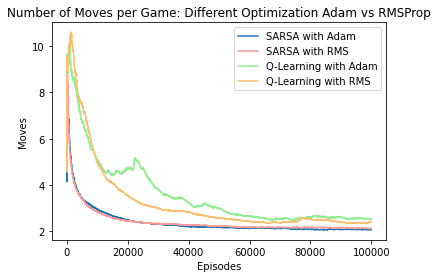

In [180]:
# load data from csv file (take ema file)
qlearning_moves_replay_rms = pd.read_csv("csv/ema_n_moves_qlearning_replay_rms.csv")
qlearning_moves_replay_rms = qlearning_moves_replay_rms.iloc[: , 1:]

qlearning_moves_replay = pd.read_csv("csv/ema_n_moves_qlearning_replay.csv")
qlearning_moves_replay = qlearning_moves_replay.iloc[: , 1:]

sarsa_moves = pd.read_csv('csv/ema_n_moves_sarsa.csv')
sarsa_moves = sarsa_moves.iloc[: , 1:]

sarsa_moves_rms = pd.read_csv('csv/ema_n_moves_sarsa_rms.csv')
sarsa_moves_rms = sarsa_moves_rms.iloc[: , 1:]

# plot
plt.plot(sarsa_moves[10:], label="SARSA with Adam", color=sarsa_color)
plt.plot(sarsa_moves_rms[10:], label="SARSA with RMS", color=sarsa_color_rms)
plt.plot(qlearning_moves_replay[10:], label="Q-Learning with Adam", color=qlearning_replay_color)
plt.plot(qlearning_moves_replay_rms[10:], label="Q-Learning with RMS", color=qlearning_color_rms)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game: Different Optimization Adam vs RMSProp")
plt.legend()
plt.savefig("pdf/moves_optimization_comparison.pdf")
plt.show()

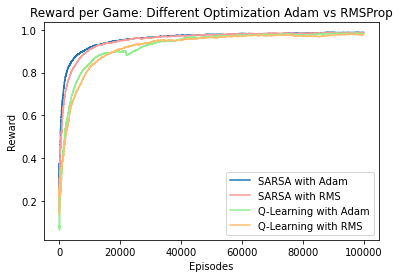

In [181]:
# load data from csv file (take ema file)
qlearning_reward_replay_rms = pd.read_csv("csv/ema_reward_qlearning_replay_rms.csv")
qlearning_reward_replay_rms  = qlearning_reward_replay_rms .iloc[: , 1:]

qlearning_reward_replay = pd.read_csv("csv/ema_reward_qlearning_replay.csv")
qlearning_reward_replay = qlearning_reward_replay.iloc[: , 1:]

sarsa_reward = pd.read_csv('csv/ema_reward_sarsa.csv')
sarsa_reward = sarsa_reward.iloc[: , 1:]

sarsa_reward_rms = pd.read_csv('csv/ema_reward_sarsa_rms.csv')
sarsa_reward_rms = sarsa_reward_rms.iloc[: , 1:]

# plot
plt.plot(sarsa_reward[10:], label="SARSA with Adam", color=sarsa_color)
plt.plot(sarsa_reward_rms[10:], label="SARSA with RMS", color=sarsa_color_rms)
plt.plot(qlearning_reward_replay[10:], label="Q-Learning with Adam", color=qlearning_replay_color)
plt.plot(qlearning_reward_replay_rms[10:], label="Q-Learning with RMS", color=qlearning_color_rms)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game: Different Optimization Adam vs RMSProp")
plt.legend()
plt.savefig("pdf/reward_adapted_reward_comparison.pdf")
plt.show()

## Plots: Overall Comparison

### Number of Moves per Game vs Training Time

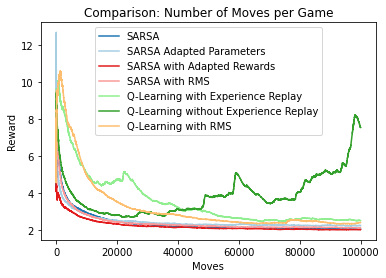

In [182]:
plt.plot(sarsa_moves[10:], label="SARSA", color=sarsa_color)
plt.plot(sarsa_moves_changed[10:], label="SARSA Adapted Parameters", color=sarsa_color_changed)
plt.plot(sarsa_moves_adapted_reward[10:], label="SARSA with Adapted Rewards", color=sarsa_adapted_reward_color)
plt.plot(sarsa_moves_rms[10:], label="SARSA with RMS", color=sarsa_color_rms)
plt.plot(qlearning_moves_replay[10:], label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.plot(qlearning_moves[10:], label="Q-Learning without Experience Replay", color=qlearning_color)
#plt.plot(qlearning_moves_replay_adapted_reward[10:], label="Q-Learning with Adapted Rewards", color=qlearning_replay_adapted_color)
plt.plot(qlearning_moves_replay_rms[10:], label="Q-Learning with RMS", color=qlearning_color_rms)
plt.xlabel("Moves")
plt.ylabel("Reward")
plt.title("Comparison: Number of Moves per Game")
plt.legend()
plt.savefig("pdf/moves_comparison.pdf")
plt.show()

#### SARSA

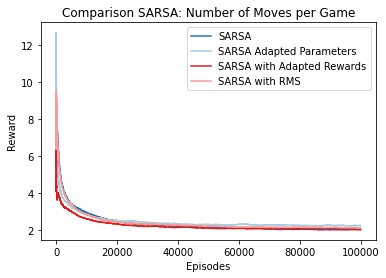

In [183]:
plt.plot(sarsa_moves[10:], label="SARSA", color=sarsa_color)
plt.plot(sarsa_moves_changed[10:], label="SARSA Adapted Parameters", color=sarsa_color_changed)
plt.plot(sarsa_moves_adapted_reward[10:], label="SARSA with Adapted Rewards", color=sarsa_adapted_reward_color)
plt.plot(sarsa_moves_rms[10:], label="SARSA with RMS", color=sarsa_color_rms)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Comparison SARSA: Number of Moves per Game")
plt.legend()
plt.savefig("pdf/moves_sarsa_all_comparison.pdf")
plt.show()

#### Q-Learning

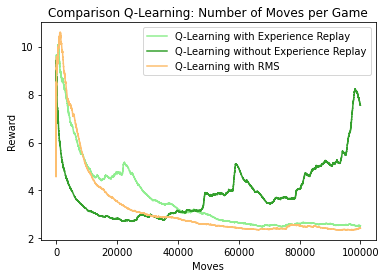

In [184]:
plt.plot(qlearning_moves_replay[10:], label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.plot(qlearning_moves[10:], label="Q-Learning without Experience Replay", color=qlearning_color)
#plt.plot(qlearning_moves_replay_adapted_reward[10:], label="Q-Learning with Adapted Rewards", color=qlearning_replay_adapted_color)
plt.plot(qlearning_moves_replay_rms[10:], label="Q-Learning with RMS", color=qlearning_color_rms)
plt.xlabel("Moves")
plt.ylabel("Reward")
plt.title("Comparison Q-Learning: Number of Moves per Game")
plt.legend()
plt.savefig("pdf/moves_qlearning_all_comparison.pdf")
plt.show()

### Reward per Game vs Training Time

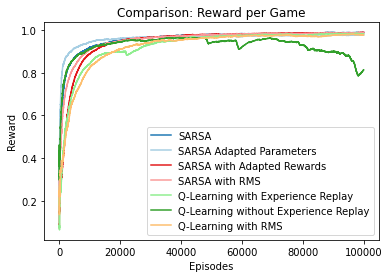

In [185]:
plt.plot(sarsa_reward[10:], label="SARSA", color=sarsa_color)
plt.plot(sarsa_reward_changed[10:], label="SARSA Adapted Parameters", color=sarsa_color_changed)
plt.plot(sarsa_reward_adapted_reward_div10[10:], label="SARSA with Adapted Rewards", color=sarsa_adapted_reward_color)
plt.plot(sarsa_reward_rms[10:], label="SARSA with RMS", color=sarsa_color_rms)
plt.plot(qlearning_reward_replay[10:], label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.plot(qlearning_reward[10:], label="Q-Learning without Experience Replay", color=qlearning_color)
#plt.plot(qlearning_reward_replay_adapted_reward[10:], label="Q-Learning with Adapted Rewards", color=qlearning_replay_adapted_color)
plt.plot(qlearning_reward_replay_rms[10:], label="Q-Learning with RMS", color=qlearning_color_rms)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Comparison: Reward per Game")
plt.legend()
plt.savefig("pdf/reward_comparison.pdf")
plt.show()

#### SARSA

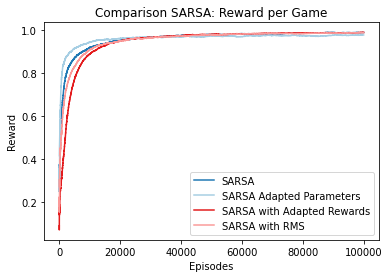

In [186]:
plt.plot(sarsa_reward[10:], label="SARSA", color=sarsa_color)
plt.plot(sarsa_reward_changed[10:], label="SARSA Adapted Parameters", color=sarsa_color_changed)
plt.plot(sarsa_reward_adapted_reward_div10[10:], label="SARSA with Adapted Rewards", color=sarsa_adapted_reward_color)
plt.plot(sarsa_reward_rms[10:], label="SARSA with RMS", color=sarsa_color_rms)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Comparison SARSA: Reward per Game")
plt.legend()
plt.savefig("pdf/reward_sarsa_all_comparison.pdf")
plt.show()

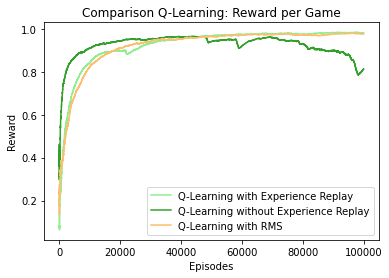

In [187]:
plt.plot(qlearning_reward_replay[10:], label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.plot(qlearning_reward[10:], label="Q-Learning without Experience Replay", color=qlearning_color)
#plt.plot(qlearning_reward_replay_adapted_reward[10:], label="Q-Learning with Adapted Rewards", color=qlearning_replay_adapted_color)
plt.plot(qlearning_reward_replay_rms[10:], label="Q-Learning with RMS", color=qlearning_color_rms)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Comparison Q-Learning: Reward per Game")
plt.legend()
plt.savefig("pdf/reward_qlearning_all_comparison.pdf")
plt.show()

## Tests: Average Moves and Reward per Model

In [ ]:
test_episodes = 1000

In [227]:
def test(agent, N_test_episodes, max_T, adapted_reward=False):
    t = trange(N_test_episodes, desc='Bar desc', leave=True)
    epsilon = 0 # no random actions
    for e in t:
        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        S, X, allowed_a = testing_env.Initialise_game()  ## INITIALISE GAME
       
        time = 1
        
        while Done == 0:
            a = agent.epsilon_greedy(X, allowed_a, epsilon)   # get action from greedy
            # take action a
            S_next, X_next, allowed_a_next, R, Done = testing_env.OneStep(a, adapted_reward)

            # if number of iterations is max nr of iterations, set to Done  
            if time == max_T:
                Done = 1 

            ## THE EPISODE HAS ENDED, update reward and number of moves
            if Done == 1:
                # progress bar
                t.set_description(f"Epoch {e+1}/{N_test_episodes}")
                t.set_postfix(moves = time,
                              reward = R)   
                agent.R_save[e] = np.copy(R)
                agent.N_moves_save[e] = np.copy(time)
                break
            
            # update parameters (state, allowed actions, action)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
            time += 1

In [223]:
# TEST SARSA 
# initialize a game
S,X,allowed_a = testing_env.Initialise_game()

N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0] 
agent = SarsaAgent(N_a,N_in,N_episodes=test_episodes) #initialize our sarsa agent network

# load model
agent.load("models/sarsa.h5")
# test algorithm
test(agent, test_episodes, max_T)

average_moves = float(np.mean(agent.N_moves_save))
average_reward = float(np.mean(agent.R_save))
print("SARSA Agent Testing - Average moves:", average_moves, "and Average Reward:", average_reward)

Epoch 999/1000: 100%|███████████████████████████| 1000/1000 [01:14<00:00, 13.42it/s, moves_average=1, reward_average=1]

SARSA Agent Testing - Average moves: 1.918 and Average Reward: 0.999


In [224]:
# TEST SARSA RMS
# initialize a game
S,X,allowed_a = testing_env.Initialise_game()

N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0] 
agent = SarsaAgent(N_a,N_in,N_episodes=test_episodes) #initialize our sarsa agent network

# load model
agent.load("models/sarsachess_RMS.h5")
# test algorithm
test(agent, test_episodes, max_T)

average_moves = float(np.mean(agent.N_moves_save))
average_reward = float(np.mean(agent.R_save))
print("SARSA RMS Testing - Average moves:", average_moves, "and Average Reward:", average_reward)

Epoch 999/1000: 100%|███████████████████████████| 1000/1000 [01:18<00:00, 12.79it/s, moves_average=1, reward_average=1]

SARSA RMS Testing - Average moves: 2.049 and Average Reward: 1.0


In [225]:
# TEST SARSA Changed Parameter
# initialize a game
S,X,allowed_a = testing_env.Initialise_game()

N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0] 
agent = SarsaAgent(N_a,N_in,N_episodes=test_episodes) #initialize our sarsa agent network

# load model
agent.load("models/sarsachess_changed.h5")
# test algorithm
test(agent, test_episodes, max_T)

average_moves = float(np.mean(agent.N_moves_save))
average_reward = float(np.mean(agent.R_save))
print("SARSA Changed Parameters Testing - Average moves:", average_moves, "and Average Reward:", average_reward)

Epoch 999/1000: 100%|███████████████████████████| 1000/1000 [01:21<00:00, 12.20it/s, moves_average=4, reward_average=1]

SARSA RMS Testing - Average moves: 2.174 and Average Reward: 0.999


In [226]:
# TEST Q-Learning Replay
# initialize a game
S,X,allowed_a = testing_env.Initialise_game()

N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0] 
agent = SarsaAgent(N_a,N_in,N_episodes=test_episodes) #initialize our sarsa agent network

# load model
agent.load("models/qchess_replay.h5")
# test algorithm
test(agent, test_episodes, max_T)

average_moves = float(np.mean(agent.N_moves_save))
average_reward = float(np.mean(agent.R_save))
print("Q-LEARNING REPLAY Testing - Average moves:", average_moves, "and Average Reward:", average_reward)

Epoch 999/1000: 100%|███████████████████████████| 1000/1000 [01:36<00:00, 10.38it/s, moves_average=2, reward_average=1]

Q-LEARNING REPLAY Testing - Average moves: 2.542 and Average Reward: 0.997


In [228]:
# TEST Q-Learning 
# initialize a game
S,X,allowed_a = testing_env.Initialise_game()

N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0] 
agent = SarsaAgent(N_a,N_in,N_episodes=test_episodes) #initialize our sarsa agent network

# load model
agent.load("models/qlearning_chess.h5")
# test algorithm
test(agent, test_episodes, max_T)

average_moves = float(np.mean(agent.N_moves_save))
average_reward = float(np.mean(agent.R_save))
print("Q-LEARNING Testing - Average moves:", average_moves, "and Average Reward:", average_reward)

Epoch 1000/1000: 100%|████████████████████████████████████████| 1000/1000 [11:36<00:00,  1.44it/s, moves=200, reward=0]

Q-LEARNING Testing - Average moves: 21.559 and Average Reward: 0.901


In [229]:
# TEST Q-Learning Replay RMS
# initialize a game
S,X,allowed_a = testing_env.Initialise_game()

N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0] 
agent = SarsaAgent(N_a,N_in,N_episodes=test_episodes) #initialize our sarsa agent network

# load model
agent.load("models/qchess_rms.h5")
# test algorithm
test(agent, test_episodes, max_T)

average_moves = float(np.mean(agent.N_moves_save))
average_reward = float(np.mean(agent.R_save))
print("Q-LEARNING REPLAY RMS Testing - Average moves:", average_moves, "and Average Reward:", average_reward)

Epoch 1000/1000: 100%|██████████████████████████████████████████| 1000/1000 [01:17<00:00, 12.91it/s, moves=4, reward=1]

Q-LEARNING REPLAY RMS Testing - Average moves: 2.349 and Average Reward: 0.997
